In [ ]:
!pip install scikit-learn xgboost pandas numpy

In [ ]:
!pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
import torch

if torch.cuda.is_available():
    print("目前 GPU 代號: " + str(torch.cuda.current_device()))
else:
    print("不支援 GPU")

In [1]:
'''
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn/notebook
https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html
'''
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import class_weight
import xgboost as xgb
from xgboost import plot_importance

In [2]:
'''
筆記:
weights = total_samples / (n_classes * class_samples * 1.0)

A類別權重 = 6500 / (4 * 1000 * 1.0) = 6500 / 4000 = 1.625
B類別權重 = 6500 / (4 * 2000 * 1.0) = 6500 / 8000 = 0.8125
C類別權重 = 6500 / (4 * 2500 * 1.0) = 6500 / 10000 = 0.65
D類別權重 = 6500 / (4 * 1000 * 1.0) = 6500 / 4000 = 1.625
'''

'''
全域設定
'''
# 分類器初始化，設定模型參數
'''
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.16, 'colsample_bytree': 0.5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 30, 'max_depth': None, 'learning_rate': 0.03, 'colsample_bytree': 0.8}
'''
xgb_model = xgb.XGBClassifier(
    objective = 'multi:softprob',
    n_estimators = 30,
    max_depth = None,
    learning_rate = 0.03,
    colsample_bytree = 0.8,
    n_jobs = -1
)


'''
主要函式
'''
# 切割資料
def split_data():
    try:
        # 取得訓練資料
        df = pd.read_csv('./train_dec08_task3.csv')
        X = df.iloc[:, :14].values #[2,3,4,5,6,7,8,9,10,11,12]
        y = df['class'].values
        
        # 將 label 的順序，從文字轉成數字格式
        Ly = LabelEncoder()
        y = Ly.fit_transform(y)
        print(y)
        print(Ly.classes_)
        
        # 切割資料
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        print(X_train.shape)
        print(X_test.shape)
        
        # 回傳切割結果
        return X_train, X_test, y_train, y_test
    except Exception as err:
        print(str(err))
        
# 訓練切割後的資料，並儲存模型
def train(X_train, X_test, y_train, y_test):
    global xgb_model
    
    try:
        # 訓練模型
        xgb_model.fit(
            X_train, 
            y_train, 
            eval_metric="mlogloss", 
            early_stopping_rounds=5, 
            eval_set=[(X_test, y_test)]
        )
        
        # 預測結果
        y_pred = xgb_model.predict(X_test)
        
        # 儲存 model
        xgb_model.save_model("task03_model.json")
        
        # 回傳 model 跟 測試資料的預測結果
        return xgb_model, y_pred
    except Exception as err:
        print(str(err))

# 訓練全部資料(不切割)，並儲存模型
def train_all():
    try:
        # 取得訓練資料
        df = pd.read_csv('./train_dec08_task3.csv')
        X = df.iloc[:,:14].values
        y = df['class'].values
        
        # 將 label 的順序，從文字轉成數字格式
        Ly = LabelEncoder()
        y = Ly.fit_transform(y)
        
        # 取得各個類別的權重
        classes_weights = class_weight.compute_sample_weight(
            class_weight = 'balanced',
            y = df['class']
        )
        
        # 設定模型參數
        xgb_model = xgb.XGBClassifier(
            objective = 'multi:softprob',
            n_estimators = 30,
            max_depth = None,
            learning_rate = 0.03,
            colsample_bytree = 0.8,
            n_jobs = -1
        )
        
        # 訓練模型
        xgb_model.fit(X, y, sample_weight = classes_weights)
        
        # 儲存 model
        xgb_model.save_model("task03_model.json")
    except Exception as err:
        print(str(err))
        
# 預測結果
def predict():
    global xgb_model
    
    try:
        # 讀取模型
        xgb_model.load_model("task03_model.json")
        
        # 讀取測試集
        df = pd.read_csv('./test_dec08_task3_only_features.csv')
        X = df.iloc[:,:14].values
        
        # 進行預測
        y_pred = xgb_model.predict(X)
        
        # 建立 submission 資料
        dict_headers = {
            "Id": [(x + 1) for x in range(len(y_pred))],
            "Category": y_pred
        }
        
        # 將 dict 轉成 dataframe，並檢視結果
        df = pd.DataFrame(dict_headers)
        df['Category'] = df['Category'].replace([0], 'A')
        df['Category'] = df['Category'].replace([1], 'B')
        df['Category'] = df['Category'].replace([2], 'C')
        df['Category'] = df['Category'].replace([3], 'D')
        print(df)
        
        # 儲存成 csv，以便上傳結果至 kaggle
        df.to_csv('submission_task03.csv', index=False)
    except Exception as err:
        print(str(err))
        
        
'''
檢視設定與結果
'''
# 取得最佳參數
def show_best_params(X_train, y_train):
    try:
        # 分類器初始化
        xgb_model = xgb.XGBClassifier(random_state = 42)
        
        # 參數範圍初始化
        n_estimators = [int(x) for x in np.linspace(start=10, stop=200, num=20)]
        max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=11)]
        max_depth.append(None)
        learning_rate=[round(float(x),2) for x in np.linspace(start=0.01, stop=0.2, num=10)]
        colsample_bytree =[round(float(x),2) for x in np.linspace(start=0.1, stop=1, num=10)]
        
        # 尋找合適參與的資料格式
        random_grid = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'colsample_bytree': colsample_bytree
        }
        
        # 透過交叉驗證來取得參數
        xg_random = RandomizedSearchCV(
            estimator = xgb_model, 
            param_distributions = random_grid, 
            n_iter = 100, 
            cv = 3, 
            verbose = 3, 
            random_state = 42, 
            n_jobs = -1
        )
        
        # 透過訓練來尋找合適參數組合
        xg_random.fit(X_train, y_train)
        
        print(xg_random.best_params_)
        
    except Exception as err:
        print(str(err))

# 計算各項評估分數
def show_scores(m, x_train, x_test, y_train, y_test, train=True):
    try:
        if train: # 計算 使用訓練資料 的評估結果
            pred = m.predict(x_train)
            print('Train Result:')
            print(f"- Accuracy Score: {accuracy_score(y_train, pred)*100:.2f}%")
            print(f"- Precision Score: {precision_score(y_train, pred, average='micro')*100:.2f}%")
            print(f"- Recall Score: {recall_score(y_train, pred, average='micro')*100:.2f}%")
            print(f"- F1 score: {f1_score(y_train, pred, average='micro')*100:.2f}%")
            print(f"Confusion Matrix:\n {confusion_matrix(y_train, pred)}")
            print()
        elif train == False: # 計算 使用測試資料 的評估結果
            pred = m.predict(x_test)
            print('Test Result:')
            print(f"- Accuracy Score: {accuracy_score(y_test, pred)*100:.2f}%")
            print(f"- Precision Score: {precision_score(y_test, pred, average='micro')*100:.2f}%")
            print(f"- Recall Score: {recall_score(y_test, pred, average='micro')*100:.2f}%")
            print(f"- F1 score: {f1_score(y_test, pred, average='micro')*100:.2f}%")
            print(f"Confusion Matrix:\n {confusion_matrix(y_test, pred)}")
            print()
    except Exception as err:
        print(str(err))
    
# 顯示特徵重要性
def show_feature_importance(xgb_model):
    try:
        plot_importance(xgb_model)
        print('特徵重要程度: ' + xgb_model.feature_importances_)
    except Exception as err:
        print(str(err))

In [66]:
'''
主程式 - 尋找合適的參數
'''
if __name__ == "__main__":
    try:
        # 切割資料
        X_train, X_test, y_train, y_test = split_data()

        # 取得最佳參數
        show_best_params(X_train, y_train)
    except Exception as err:
        print(str(err))

[0 0 0 ... 3 3 3]
['A' 'B' 'C' 'D']
(4550, 14)
(1950, 14)
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 30, 'max_depth': None, 'learning_rate': 0.03, 'colsample_bytree': 0.8}


[0 0 0 ... 3 3 3]
['A' 'B' 'C' 'D']
(4550, 14)
(1950, 14)
[0]	validation_0-mlogloss:1.37533
[1]	validation_0-mlogloss:1.36642
[2]	validation_0-mlogloss:1.35642
[3]	validation_0-mlogloss:1.34707
[4]	validation_0-mlogloss:1.33819
[5]	validation_0-mlogloss:1.33140
[6]	validation_0-mlogloss:1.32445
[7]	validation_0-mlogloss:1.31776
[8]	validation_0-mlogloss:1.31067
[9]	validation_0-mlogloss:1.30414
[10]	validation_0-mlogloss:1.29868

C:\Users\Owner\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[11]	validation_0-mlogloss:1.29202
[12]	validation_0-mlogloss:1.28642
[13]	validation_0-mlogloss:1.28100
[14]	validation_0-mlogloss:1.27595
[15]	validation_0-mlogloss:1.27061
[16]	validation_0-mlogloss:1.26592
[17]	validation_0-mlogloss:1.26099
[18]	validation_0-mlogloss:1.25612
[19]	validation_0-mlogloss:1.25192
[20]	validation_0-mlogloss:1.24801
[21]	validation_0-mlogloss:1.24383
[22]	validation_0-mlogloss:1.23996
[23]	validation_0-mlogloss:1.23654
[24]	validation_0-mlogloss:1.23329
[25]	validation_0-mlogloss:1.22983
[26]	validation_0-mlogloss:1.22636
[27]	validation_0-mlogloss:1.22330
[28]	validation_0-mlogloss:1.22043
[29]	validation_0-mlogloss:1.21708
best score: 1.2170831437752796, best iteration: 29, best ntree limit 30
Train Result:
- Accuracy Score: 59.23%
- Precision Score: 59.23%
- Recall Score: 59.23%
- F1 score: 59.23%
Confusion Matrix:
 [[  52  263  375    0]
 [   0 1033  371    1]
 [   0  216 1539    2]
 [   2  410  215   71]]

Test Result:
- Accuracy Score: 50.51%
- Pr

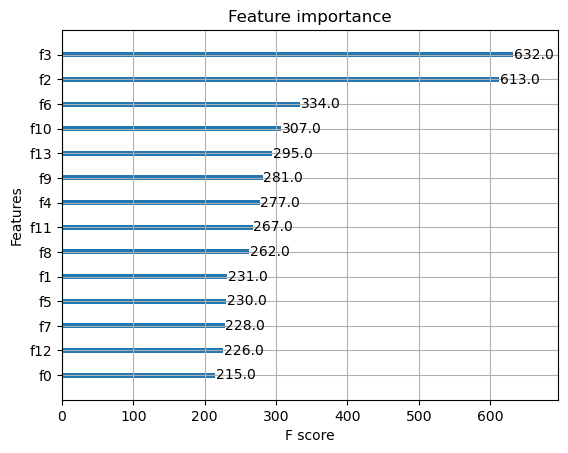

In [68]:
'''
主程式 - 訓練 和 檢視結果，並儲存 model
'''
if __name__ == "__main__":
    try:
        # 切割資料
        X_train, X_test, y_train, y_test = split_data()

        # 訓練模型，並取得測試資料預測結果
        xgb_model, y_pred = train(X_train, X_test, y_train, y_test)

        # 輸出評估結果
        print(f"best score: {xgb_model.best_score}, best iteration: {xgb_model.best_iteration}, best ntree limit {xgb_model.best_ntree_limit}")
        show_scores(xgb_model, X_train, X_test, y_train, y_test, train=True)
        show_scores(xgb_model, X_train, X_test, y_train, y_test, train=False)
        show_feature_importance(xgb_model)
    except Exception as err:
        print(str(err))

In [73]:
'''
主程式 - 訓練完整的訓練資料(不評估模型)，並儲存 model
'''
if __name__ == "__main__":
    try:
        train_all()
    except Exception as err:
        print(str(err))

In [74]:
'''
主程式 - 預測結果 與 儲存 submission 用的 csv
'''
if __name__ == "__main__":
    try:
        # 讀取官方所提供的無 label 特徵資料 (test data)，預測結果 (類別) 並儲存成 csv
        predict()
    except Exception as err:
        print(str(err))

        Id Category
0        1        A
1        2        D
2        3        D
3        4        B
4        5        C
...    ...      ...
1595  1596        A
1596  1597        D
1597  1598        B
1598  1599        B
1599  1600        C

[1600 rows x 2 columns]
